### [Image Mining 2020] Lab 2 ‒ Deep Learning

**Author:** Imad Eddine **MAROUF**
> Email: imad.marouf97@gmail.com

**Author:** Lukas **MALIK**
> Email: lukas.malik@web.de

**Due date:** 22.10.2020

--------------------------------------------------------------------------------------------------------

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms

import time

In [2]:
!pip install torch-summary

In [3]:
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

if torch.cuda.is_available():
  # Make CuDNN Determinist
  torch.backends.cudnn.deterministic = True
  torch.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 40000 # Max: 50 000 - n_val_samples
n_val_samples = 10000


train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))
#test_sampler = SubsetRandomSampler(np.arange(n_test_samples, dtype=np.int64))  # we can use it to test on a subset
# (In the last case, indexes do not need to account for training ones because the train=False parameter in datasets.CIFAR will select from the test set)

In [5]:
num_workers = 5
test_batch_size = 4

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


# 1 \Shallow Convolutionnal Neural Network

For graphical recognition, convolutions offer a performance enhancement. We trained a convolutionnal neural network CNN with **two convolutionnal layers and one hidden linear layer**.

Between each convolutionnal layer, we used **a leaky relu activation** and **a max-pool layer**, as well as **a leaky relu activation** for the hidden linear layer. Again we used the negative log likelihood loss and the log softmax activation for the final layer as it is standard for classification with C classes

In [6]:
# Useful imports
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5)
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
            

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [7]:
import torch.optim as optim

def createLossAndOptimizer(net, learning_rate=0.001):
    # it combines softmax with negative log likelihood loss
    criterion = nn.CrossEntropyLoss()  
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    return criterion, optimizer

In [8]:
def get_train_loader(batch_size):
    return torch.utils.data.DataLoader(train_set, batch_size=batch_size, sampler=train_sampler,
                                              num_workers=num_workers)
# Use larger batch size for validation to speed up computation
val_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)

In [9]:
def train(net, batch_size, n_epochs, learning_rate):
    """
    Train a neural network and print statistics of the training
    :param net: (PyTorch Neural Network)
    :param batch_size: (int)
    :param n_epochs: (int)  Number of iterations on the training set
    :param learning_rate: (float) learning rate used by the optimizer
    """
    print("===== HYPERPARAMETERS =====")
    print("batch_size=", batch_size)
    print("n_epochs=", n_epochs)
    print("learning_rate=", learning_rate)
    print("=" * 30)
    
    train_loader = get_train_loader(batch_size)
    n_minibatches = len(train_loader)

    criterion, optimizer = createLossAndOptimizer(net, learning_rate)
    # Init variables used for plotting the loss
    train_history = []
    val_history = []

    training_start_time = time.time()
    best_error = np.inf
    best_model_path = "best_model.pth"
    # Move model to gpu if possible
    net = net.to(device)

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        running_loss = 0.0
        print_every = n_minibatches // 10
        start_time = time.time()
        total_train_loss = 0
        
        for i, (inputs, labels) in enumerate(train_loader):
            # Move tensors to correct device
            inputs, labels = inputs.to(device), labels.to(device)
            
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            #print(outputs.shape)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            total_train_loss += loss.item()

            # print every 10th of epoch
            if (i + 1) % (print_every + 1) == 0:    
                print("Epoch {}, {:d}% \t train_loss: {:.2f} took: {:.2f}s".format(
                      epoch + 1, int(100 * (i + 1) / n_minibatches), running_loss / print_every,
                      time.time() - start_time))
                running_loss = 0.0
                start_time = time.time()

        train_history.append(total_train_loss / len(train_loader))

        total_val_loss = 0
        # Do a pass on the validation set
        # We don't need to compute gradient,
        # we save memory and computation using th.no_grad()
        with torch.no_grad():
          for inputs, labels in val_loader:
              # Move tensors to correct device
              inputs, labels = inputs.to(device), labels.to(device)
              # Forward pass
              predictions = net(inputs)
              val_loss = criterion(predictions, labels)
              total_val_loss += val_loss.item()
            
        val_history.append(total_val_loss / len(val_loader))
        # Save model that performs best on validation set
        if total_val_loss < best_error:
            best_error = total_val_loss
            torch.save(net.state_dict(), best_model_path)

        print("Validation loss = {:.2f}".format(total_val_loss / len(val_loader)))

    print("Training Finished, took {:.2f}s".format(time.time() - training_start_time))
    
    # Load best model
    net.load_state_dict(torch.load(best_model_path))
    
    return train_history, val_history

In [13]:
cnn = CNN()

In [15]:
from torchsummary import summary

print(summary(cnn))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            456
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            2,416
├─Linear: 1-4                            48,120
├─Linear: 1-5                            10,164
├─Linear: 1-6                            850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0
Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            456
├─MaxPool2d: 1-2                         --
├─Conv2d: 1-3                            2,416
├─Linear: 1-4                            48,120
├─Linear: 1-5                            10,164
├─Linear: 1-6                            850
Total params: 62,006
Trainable params: 62,006
Non-trainable params: 0


In [14]:
train_history, val_history = train(cnn, batch_size=32, n_epochs=10, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 2.14 took: 1.47s
Epoch 1, 20% 	 train_loss: 1.84 took: 1.16s
Epoch 1, 30% 	 train_loss: 1.72 took: 1.12s
Epoch 1, 40% 	 train_loss: 1.63 took: 1.15s
Epoch 1, 50% 	 train_loss: 1.61 took: 1.12s
Epoch 1, 60% 	 train_loss: 1.54 took: 1.27s
Epoch 1, 70% 	 train_loss: 1.55 took: 1.20s
Epoch 1, 80% 	 train_loss: 1.52 took: 1.17s
Epoch 1, 90% 	 train_loss: 1.49 took: 1.24s
Validation loss = 1.50
Epoch 2, 10% 	 train_loss: 1.44 took: 1.37s
Epoch 2, 20% 	 train_loss: 1.42 took: 1.13s
Epoch 2, 30% 	 train_loss: 1.40 took: 1.14s
Epoch 2, 40% 	 train_loss: 1.37 took: 1.14s
Epoch 2, 50% 	 train_loss: 1.39 took: 1.13s
Epoch 2, 60% 	 train_loss: 1.35 took: 1.12s
Epoch 2, 70% 	 train_loss: 1.36 took: 1.17s
Epoch 2, 80% 	 train_loss: 1.34 took: 1.16s
Epoch 2, 90% 	 train_loss: 1.35 took: 1.15s
Validation loss = 1.34
Epoch 3, 10% 	 train_loss: 1.29 took: 1.49s
Epoch 3, 20% 	 train_loss: 1.27 took: 1.1

In [15]:
# Colors from Colorbrewer Paired_12
colors = [[31, 120, 180], [51, 160, 44]]
colors = [(r / 255, g / 255, b / 255) for (r, g, b) in colors]

# functions to show an image
def imshow(img):
    """
    :param img: (PyTorch Tensor)
    """
    # unnormalize
    img = img / 2 + 0.5     
    # Convert tensor to numpy array
    npimg = img.numpy()
    # Color channel first -> color channel last
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

In [16]:
def plot_losses(train_history, val_history):
    x = np.arange(1, len(train_history) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(x, train_history, color=colors[0], label="Training loss", linewidth=2)
    plt.plot(x, val_history, color=colors[1], label="Validation loss", linewidth=2)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.title("Evolution of the training and validation loss")
    plt.show()

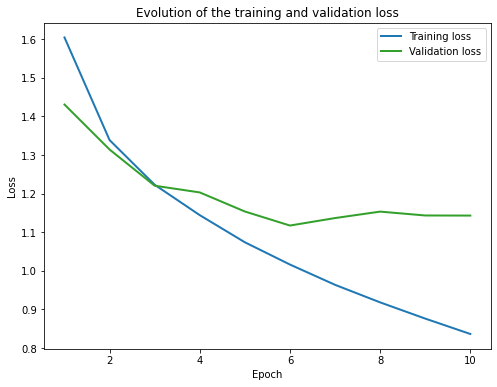

In [ ]:
plot_losses(train_history, val_history)

In [17]:
def dataset_accuracy(net, data_loader, name=""):
    net = net.to(device)
    correct = 0
    total = 0
    for images, labels in data_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum()
    accuracy = 100 * float(correct) / total
    print('\t Accuracy of the network on the {} {} images: {:.2f} %'.format(total, name, accuracy))

def train_set_accuracy(net):
    dataset_accuracy(net, train_loader, "train")

def val_set_accuracy(net):
    dataset_accuracy(net, val_loader, "validation")  
    
def test_set_accuracy(net):
    dataset_accuracy(net, test_loader, "test")

def compute_accuracy(net):
    train_set_accuracy(net)
    val_set_accuracy(net)
    test_set_accuracy(net)

In [18]:
print("--------------------- Computing accuracy of CNN Model ---------------------")
compute_accuracy(cnn)

--------------------- Computing accuracy of CNN Model ---------------------
Accuracy of the network on the 40000 train images: 70.52 %
Accuracy of the network on the 10000 validation images: 61.70 %
Accuracy of the network on the 10000 test images: 61.30 %


In [20]:
def accuracy_per_class(net):
    net = net.to(device)
    n_classes = 10
    # (real, predicted)
    confusion_matrix = np.zeros((n_classes, n_classes), dtype=np.int64)

    for images, labels in test_loader:
        images, labels = images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        for i in range(test_batch_size):
            confusion_matrix[labels[i], predicted[i]] += 1
            label = labels[i]

    print("{:<10} {:^10}".format("Class", "Accuracy (%)"))
    for i in range(n_classes):
        class_total = confusion_matrix[i, :].sum()
        class_correct = confusion_matrix[i, i]
        percentage_correct = 100.0 * float(class_correct) / class_total
        
        print('{:<10} {:^10.2f}'.format(classes[i], percentage_correct))
    return confusion_matrix

In [21]:
confusion_matrix = accuracy_per_class(cnn)

Class      Accuracy (%)
plane        62.10   
car          74.00   
bird         45.70   
cat          44.40   
deer         57.80   
dog          57.10   
frog         71.80   
horse        63.90   
ship         71.70   
truck        64.50   


**Comment**:
> - With 5 epochs, the model was doing poorly, especially for the class of deer, and car. The accuracy was 28,90%, and 46% respectively.
> - It seems that the model is overfitting, we will try Dropout to check if the accuracy will improve.

-----------------------------------------------------------------------------

# 2 \ Using DropOut:

- Dropout is a technique where randomly selected neurons are ignored during training. They are “dropped-out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass and any weight updates are not applied to the neuron on the backward pass.

> **References:** 
>> - Representing model uncertainty in deep learning - ‎Gal - Cited by 2434
>> - Variational dropout sparsifies deep neural networks - ‎Molchanov - Cited by 352
>> - Dropout: a simple way to prevent neural networks from … - ‎Srivastava - Cited by 23259

In [22]:
# Build the CNN
class CNN_with_dropout(nn.Module):
    def __init__(self, dropout=0.2):
        super(CNN_with_dropout, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5, stride=1, padding=2)
        #3*32*32 -> 32*32*32
        self.dropout1 = nn.Dropout(p=dropout)        
        self.pool1 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        #32*32*32 -> 16*16*32
        self.conv2 = nn.Conv2d(32, 64, 3, stride=1, padding=1)
        #16*16*32 -> 16*16*64
        self.dropout2 = nn.Dropout(p=dropout)
        self.pool2 = nn.MaxPool2d(kernel_size=(2,2), stride=2)
        #16*16*64 -> 8*8*64
        self.fc1 = nn.Linear(8*8*64, 1024)
        self.dropout3 = nn.Dropout(p=dropout)
        self.fc2 = nn.Linear(1024, 512)
        self.dropout4 = nn.Dropout(p=dropout)
        self.fc3 = nn.Linear(512, 10)
            

    def forward(self, x):
        x = self.dropout1(self.conv1(x))
        x = self.pool1(F.relu(x))
        x = self.dropout2(self.conv2(x))
        x = self.pool2(F.relu(x))
        x = x.view(-1, self.num_flat_features(x)) 
        #self.num_flat_features(x) = 8*8*64 here.
        #-1 means: get the rest a row (in this case is 16 mini-batches)
        #pytorch nn only takes mini-batch as the input
        
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)
        x = F.relu(self.fc2(x))
        x = self.dropout4(x)
        x = self.fc3(x)
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:] # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [23]:
cnn_with_Drop = CNN_with_dropout()

In [24]:
print(summary(cnn_with_Drop))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            2,432
├─Dropout: 1-2                           --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            18,496
├─Dropout: 1-5                           --
├─MaxPool2d: 1-6                         --
├─Linear: 1-7                            4,195,328
├─Dropout: 1-8                           --
├─Linear: 1-9                            524,800
├─Dropout: 1-10                          --
├─Linear: 1-11                           5,130
Total params: 4,746,186
Trainable params: 4,746,186
Non-trainable params: 0


Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            2,432
├─Dropout: 1-2                           --
├─MaxPool2d: 1-3                         --
├─Conv2d: 1-4                            18,496
├─Dropout: 1-5                           --
├─MaxPool2d: 1-6                         --
├─Linear: 1-7                            4,195,328
├─Dropout: 1-8                           --
├─Linear: 1-9                            524,800
├─Dropout: 1-10                          --
├─Linear: 1-11                           5,130
Total params: 4,746,186
Trainable params: 4,746,186
Non-trainable params: 0

In [25]:
train_history, val_history = train(cnn_with_Drop, batch_size=32, n_epochs=20, learning_rate=0.001)

===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 20
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 1.93 took: 1.43s
Epoch 1, 20% 	 train_loss: 1.61 took: 1.22s
Epoch 1, 30% 	 train_loss: 1.49 took: 1.36s
Epoch 1, 40% 	 train_loss: 1.41 took: 1.26s
Epoch 1, 50% 	 train_loss: 1.36 took: 1.32s
Epoch 1, 60% 	 train_loss: 1.31 took: 1.24s
Epoch 1, 70% 	 train_loss: 1.27 took: 1.26s
Epoch 1, 80% 	 train_loss: 1.24 took: 1.22s
Epoch 1, 90% 	 train_loss: 1.20 took: 1.22s
Validation loss = 1.26
Epoch 2, 10% 	 train_loss: 1.05 took: 1.42s
Epoch 2, 20% 	 train_loss: 1.01 took: 1.18s
Epoch 2, 30% 	 train_loss: 1.07 took: 1.23s
Epoch 2, 40% 	 train_loss: 1.06 took: 1.16s
Epoch 2, 50% 	 train_loss: 1.00 took: 1.18s
Epoch 2, 60% 	 train_loss: 1.00 took: 1.21s
Epoch 2, 70% 	 train_loss: 0.97 took: 1.29s
Epoch 2, 80% 	 train_loss: 0.98 took: 1.24s
Epoch 2, 90% 	 train_loss: 1.00 took: 1.31s
Validation loss = 1.00
Epoch 3, 10% 	 train_loss: 0.85 took: 1.45s
Epoch 3, 20% 	 train_loss: 0.82 took: 1.3

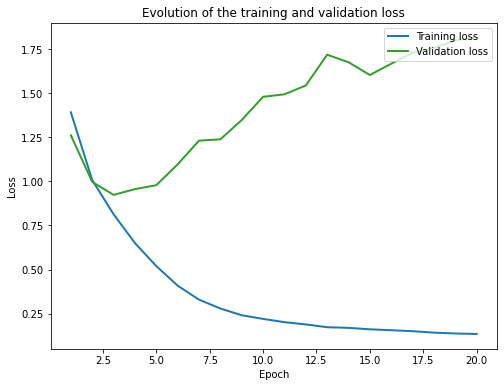

In [26]:
plot_losses(train_history, val_history)

In [27]:
print("--------------- Computing accuracy of CNN with Dropout(0.1) ---------------")
compute_accuracy(cnn_with_Drop)

--------------- Computing accuracy of CNN with Dropout(0.1) ---------------
Accuracy of the network on the 40000 train images: 79.13 %
Accuracy of the network on the 10000 validation images: 68.57 %
Accuracy of the network on the 10000 test images: 68.41 %


In [28]:
confusion_matrix = accuracy_per_class(cnn_with_Drop)

Class      Accuracy (%)
plane        79.10   
car          79.00   
bird         48.70   
cat          47.90   
deer         57.20   
dog          55.40   
frog         80.70   
horse        80.00   
ship         75.30   
truck        78.00   


**Comment:**
> - Using 0.9 value for the dropout with 20 epochs training, led to an overfitting as we can see in the illustration above, where the loss of the training set is decreasing while on the validation is increasing which demonstrates that the model is overfitting ("We are using much more neurons, and the weights of the model are being adjusted to fit the training set rather than generelizing the prediction"). 
> - Solution to avoid this overfitting issue might be: 
>> - Increasing the value of dropout probability to use less neurons.
>> - We can using early stopping technique or use only 14 epochs since we can see that the loss does not decrement that much after 14 epochs.

## 2.1 \ Testing with Different Dropout values: 

In [ ]:
probs = [0.3, 0.5, 0.9]
for i in probs:
  print("------------------ Dropout: {} ------------------".format(i))
  cnn_with_Drop = CNN_with_dropout(dropout=i)
  train_history, val_history = train(cnn_with_Drop, batch_size=32, n_epochs=10, learning_rate=0.001)
  compute_accuracy(cnn_with_Drop)
  print("-------------------------------------------------")

------------------ Dropout: 0.3 ------------------
===== HYPERPARAMETERS =====
batch_size= 32
n_epochs= 10
learning_rate= 0.001
Epoch 1, 10% 	 train_loss: 1.94 took: 1.58s
Epoch 1, 20% 	 train_loss: 1.63 took: 1.26s
Epoch 1, 30% 	 train_loss: 1.51 took: 1.21s
Epoch 1, 40% 	 train_loss: 1.42 took: 1.26s
Epoch 1, 50% 	 train_loss: 1.37 took: 1.23s
Epoch 1, 60% 	 train_loss: 1.34 took: 1.12s
Epoch 1, 70% 	 train_loss: 1.29 took: 1.13s
Epoch 1, 80% 	 train_loss: 1.23 took: 1.21s
Epoch 1, 90% 	 train_loss: 1.21 took: 1.24s
Validation loss = 1.17
Epoch 2, 10% 	 train_loss: 1.07 took: 1.37s
Epoch 2, 20% 	 train_loss: 1.09 took: 1.23s
Epoch 2, 30% 	 train_loss: 1.08 took: 1.21s
Epoch 2, 40% 	 train_loss: 1.08 took: 1.21s
Epoch 2, 50% 	 train_loss: 1.10 took: 1.14s
Epoch 2, 60% 	 train_loss: 1.06 took: 1.26s
Epoch 2, 70% 	 train_loss: 1.05 took: 1.19s
Epoch 2, 80% 	 train_loss: 1.01 took: 1.25s
Epoch 2, 90% 	 train_loss: 1.03 took: 1.24s
Validation loss = 1.04
Epoch 3, 10% 	 train_loss: 0.86 to

**Comment:**
> - As expected, increasing the value of dropout will decrease the accuracy of the model since we will have less neurons activated in our model.

------------------------------------------------------------------------------------------------

During the future experiments, we will tackle transfer learning, since why should we "reinvent the wheel", where we have state-of-the-art architecture in the literature which has been proven that they have outstanding results on well-know datasets like "ImageNET" and "CIFAR". 

# 3\ Transfer Learning using VGG-16:
- Transfer learning is specifically using a neural network that has been pre-trained on a much larger dataset. The main benefit of using transfer learning is that the neural network has already learned many important features from a large dataset. When we use that network on our own dataset, we just need to tweak a few things to achieve good results.

- We will be downloading the VGG16 from PyTorch models and it uses the weights of ImageNet. The VGG network model was introduced by Karen Simonyan and Andrew Zisserman in the paper named Very Deep Convolutional Networks for Large-Scale Image Recognition. Be sure to give the paper a read if you like to get into the details.

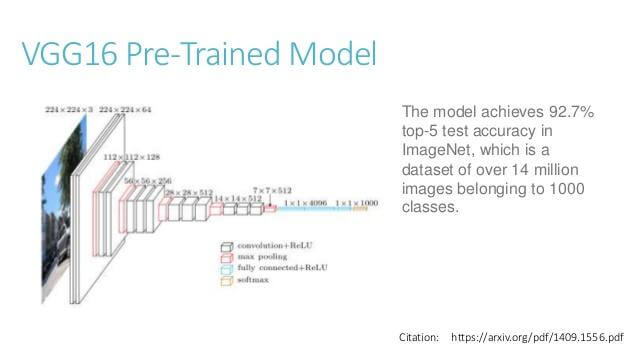

In [41]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
import time
import torch.nn.functional as F
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import models

# check GPU availability
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [42]:
torch.cuda.empty_cache()

In [44]:
#Reloading the dataset and rescaling it since VGG-16 requires specific size for input(224*224)

transform = transforms.Compose(
    [transforms.Resize((224, 224)),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=32,
                                          shuffle=True)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=32,
                                         shuffle=False)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
vgg16 = models.vgg16(pretrained=True)
vgg16.to(device)

In [31]:
print(summary(vgg16))

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─ReLU: 2-2                         --
|    └─Conv2d: 2-3                       36,928
|    └─ReLU: 2-4                         --
|    └─MaxPool2d: 2-5                    --
|    └─Conv2d: 2-6                       73,856
|    └─ReLU: 2-7                         --
|    └─Conv2d: 2-8                       147,584
|    └─ReLU: 2-9                         --
|    └─MaxPool2d: 2-10                   --
|    └─Conv2d: 2-11                      295,168
|    └─ReLU: 2-12                        --
|    └─Conv2d: 2-13                      590,080
|    └─ReLU: 2-14                        --
|    └─Conv2d: 2-15                      590,080
|    └─ReLU: 2-16                        --
|    └─MaxPool2d: 2-17                   --
|    └─Conv2d: 2-18                      1,180,160
|    └─ReLU: 2-19                        --
|    └─Conv2d: 2-20              

_We need to freeze the network since this network architecture was designed for ImagNet dataset (1000 classes), in our case we have only 10 classes._

_As well, we notice that the number of parameters in VGG16 is massive to train all of them, thus will we will focus just on the last years since there a quit overlap between the important features of images in ImageNET and CIFAR (due to the fact that the first layers in each architecture are used to extract the main features (like corners, vertical or horizontal lines), and last ones for more detailed features (like wheels for cars, eyes for birds ...etc)._

In [36]:
# change the number of classes 
vgg16.classifier[6].out_features = 10
# freeze convolution weights
for param in vgg16.features.parameters():
    param.requires_grad = False

In [37]:
# optimizer
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001, momentum=0.9)
# loss function
criterion = nn.CrossEntropyLoss()

In [38]:
# validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

In [39]:
# training function
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [ ]:
train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(10):
    train_epoch_loss, train_epoch_accuracy = fit(vgg16, trainloader)
    val_epoch_loss, val_epoch_accuracy = validate(vgg16, testloader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

Train Loss: 0.0258, Train Acc: 73.05
Train Loss: 0.0148, Train Acc: 83.55
Train Loss: 0.0117, Train Acc: 86.77
Train Loss: 0.0095, Train Acc: 89.38
Train Loss: 0.0075, Train Acc: 91.76
Train Loss: 0.0057, Train Acc: 93.64
Train Loss: 0.0044, Train Acc: 95.30
Train Loss: 0.0032, Train Acc: 96.62
Train Loss: 0.0023, Train Acc: 97.56
Train Loss: 0.0018, Train Acc: 98.27
60.14371847311656 minutes


In [ ]:
torch.save(vgg16.state_dict(), 'vgg16_model.pt')

In [47]:
import os 
print(os.getcwd())
print(os.listdir())
vgg16.load_state_dict(torch.load('vgg16_model.pt'))

/content
['.config', 'best_model.pth', 'vgg16_model.pt', 'data', 'sample_data']


<All keys matched successfully>

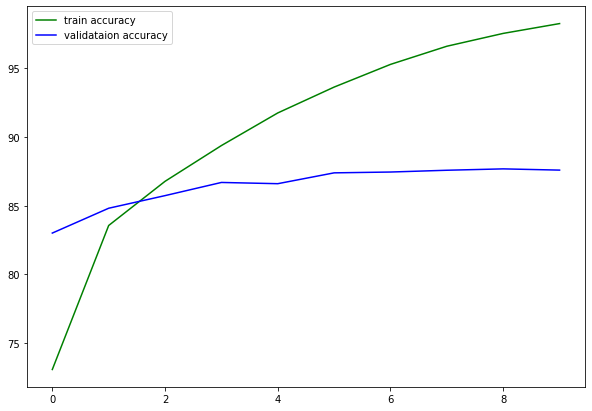

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy.png')
plt.show()

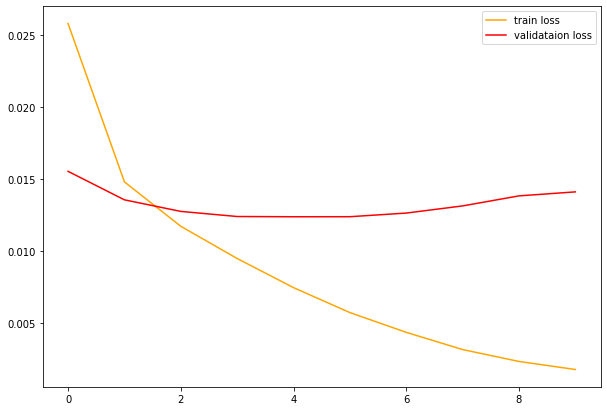

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss.png')
plt.show()

In [48]:
print("-------------------- Accuracy of VGG16 -------------------- ")
compute_accuracy(vgg16)

-------------------- Accuracy of VGG16 -------------------- 
Accuracy of the network on the 50000 train images: 98.81 %
Accuracy of the network on the 10000 validation images: 34.58 %
Accuracy of the network on the 10000 test images: 86.06 %


**Comment:**
> - Comparing to our previous CNN Model, the accuracy has improved by 25% due to the fact that VGG-16 is relatively more deep and has more weights to capture different features.

> - We could improve more the accuracy by training on more epochs, as noted in some experiments where they reached 95% with 50 epochs, but we would like to do another expriments since 86% is quite good.

------------------------------------------------------------

# 4\ Resnet-18:
- Residual Networks are very well neural network architecture type comes as a solution to the problem of degradation (When deeper networks starts converging, a degradation problem has been exposed: with the network depth increasing, accuracy gets saturated and then degrades rapidly).

> - ResNet-34 achieved a top-5 validation error of 5.71% better than BN-inception and VGG. ResNet-152 achieves a top-5 validation error of 4.49%. An ensemble of 6 models with different depths achieves a top-5 validation error of 3.57%. Winning the 1st place in ILSVRC-2015.

> - Won the 1st place in ILSVRC and COCO 2015 competition in ImageNet Detection, ImageNet localization, Coco detection and Coco segmentation.

- Since our dataset is not very big, and avoid long duration of training, we would like to ResNet-18 instead of ResNet-34. 
- **Paper:** https://arxiv.org/pdf/1512.03385.pdf

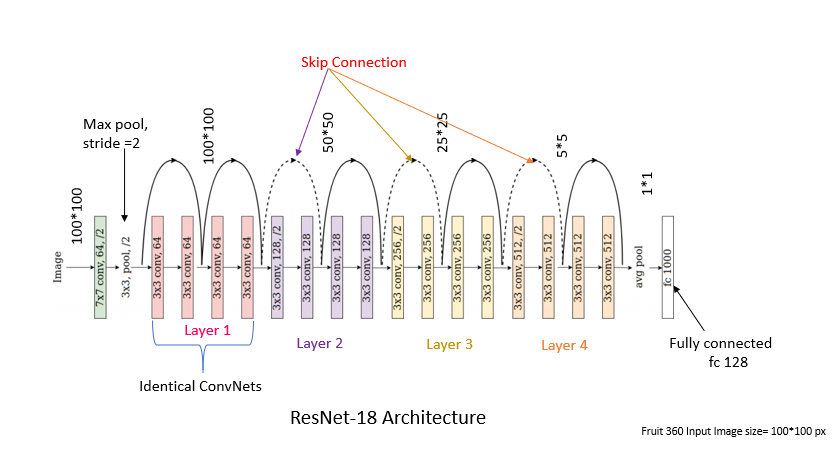

**Loading Dataset:** 
- We have to reload the datasets, since ResNet-18 requires an input of 256*256 format

In [ ]:
num_workers = 5
test_batch_size = 4

# transform images using mean and std for pretrained models

transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torchvision.models as models

resnet = models.resnet18(pretrained=True)
resnet.to(device)

In [33]:
print(summary(resnet))

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

Layer (type:depth-idx)                   Param #
├─Conv2d: 1-1                            9,408
├─BatchNorm2d: 1-2                       128
├─ReLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─BasicBlock: 2-1                   --
|    |    └─Conv2d: 3-1                  36,864
|    |    └─BatchNorm2d: 3-2             128
|    |    └─ReLU: 3-3                    --
|    |    └─Conv2d: 3-4                  36,864
|    |    └─BatchNorm2d: 3-5             128
|    └─BasicBlock: 2-2                   --
|    |    └─Conv2d: 3-6                  36,864
|    |    └─BatchNorm2d: 3-7             128
|    |    └─ReLU: 3-8                    --
|    |    └─Conv2d: 3-9                  36,864
|    |    └─BatchNorm2d: 3-10            128
├─Sequential: 1-6                        --
|    └─BasicBlock: 2-3                   --
|    |    └─Conv2d: 3-11                 73,728
|    |    └─BatchNorm2d: 3-12            25

In [ ]:
# change the number of classes 
resnet.fc.out_features = 10

# freeze 
# first freeze all 
for param in resnet.parameters():
    param.requires_grad = False
    
# then unfreeze fc and last layer 
for param in resnet.layer4.parameters():
    param.requires_grad = True

resnet.fc.weight.requires_grad = True
resnet.fc.bias.requires_grad = True

In [ ]:
# validation function
def validate(model, test_dataloader):
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    for int, data in enumerate(test_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        output = model(data)
        loss = criterion(output, target)
        
        val_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        val_running_correct += (preds == target).sum().item()
    
    val_loss = val_running_loss/len(test_dataloader.dataset)
    val_accuracy = 100. * val_running_correct/len(test_dataloader.dataset)
    
    return val_loss, val_accuracy

In [ ]:
# training function
def fit(model, train_dataloader):
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in enumerate(train_dataloader):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        train_running_loss += loss.item()
        _, preds = torch.max(output.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
    train_loss = train_running_loss/len(train_dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(train_dataloader.dataset)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.2f}')
    
    return train_loss, train_accuracy

In [ ]:
!pip install torch_optimizer

In [ ]:
import torch_optimizer as optim

# YOGI OPTIMIZER 
optimizer = optim.Yogi(resnet.parameters(), lr=0.001)

In [ ]:
## Learning Rate Finder to find best learning rate for training Resnet

I tried out the learning rate finder concept introduced in "Cyclical Learning Rates for Training Neural Networks" by Smith, 2015 retrieved from: https://arxiv.org/abs/1506.01186

In [ ]:
!pip install torch-lr-finder --quiet 

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 4.04E-03


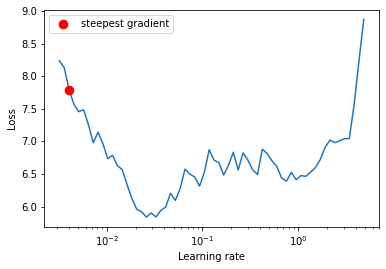

In [ ]:
from torch_lr_finder import LRFinder

# learning rate finder 
modelname = "resnet"
criterion = nn.CrossEntropyLoss()
optimizer = optim.Yogi(resnet.parameters(), lr=0.001)
lr_finder = LRFinder(resnet, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

**Comment:**
- The results are a little unstable and we did not conduct any further analysis!
- We decided to use the Yogi Optimizer with a slightly higher learning rate as the learning rate finder suggested, also since this decreased training time! We used Resnet 18 training for 50 epochs!

In [ ]:
import torch_optimizer as optim

# YOGI OPTIMIZER 
# Parameters 
learning_rate = 0.01
optimizer = optim.Yogi(filter(lambda p: p.requires_grad, resnet.parameters()), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

In [ ]:
# load model trained to epoch 50 
#resnet.load_state_dict(torch.load('{}_yogi.pth'.format(modelname)))

train_loss , train_accuracy = [], []
val_loss , val_accuracy = [], []
start = time.time()
for epoch in range(20):
    train_epoch_loss, train_epoch_accuracy = fit(resnet, train_loader)
    val_epoch_loss, val_epoch_accuracy = validate(resnet, test_loader)
    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
end = time.time()
print((end-start)/60, 'minutes')

Train Loss: 0.1884, Train Acc: 54.89
Train Loss: 0.0956, Train Acc: 66.92
Train Loss: 0.0707, Train Acc: 70.20
Train Loss: 0.0529, Train Acc: 72.71
Train Loss: 0.0395, Train Acc: 74.57
Train Loss: 0.0291, Train Acc: 76.01
Train Loss: 0.0222, Train Acc: 76.94
Train Loss: 0.0176, Train Acc: 77.65
Train Loss: 0.0138, Train Acc: 78.17
Train Loss: 0.0104, Train Acc: 78.59
Train Loss: 0.0102, Train Acc: 78.58
Train Loss: 0.0080, Train Acc: 78.89
Train Loss: 0.0064, Train Acc: 79.17
Train Loss: 0.0054, Train Acc: 79.26
Train Loss: 0.0049, Train Acc: 79.34
Train Loss: 0.0050, Train Acc: 79.36
Train Loss: 0.0041, Train Acc: 79.49
Train Loss: 0.0039, Train Acc: 79.50
Train Loss: 0.0028, Train Acc: 79.65
Train Loss: 0.0031, Train Acc: 79.57
137.08487555583318 minutes


In [ ]:
import os

torch.save(resnet.state_dict(), '{}_yogi_norm.pth'.format(modelname))
print(os.getcwd())
print(os.listdir())
resnet.load_state_dict(torch.load('{}_yogi_norm.pth'.format(modelname)))

/content
['.config', 'data', 'resnet_yogi_norm.pth', 'sample_data']


<All keys matched successfully>

In [ ]:
resnet.load_state_dict(torch.load('resnet_yogi_norm.pth'))

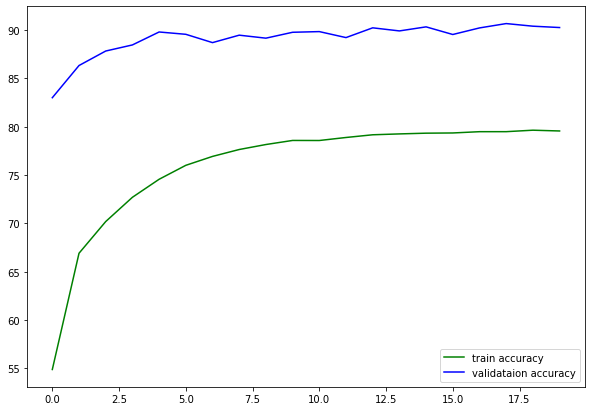

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_accuracy, color='green', label='train accuracy')
plt.plot(val_accuracy, color='blue', label='validataion accuracy')
plt.legend()
plt.savefig('accuracy_{}_norm.png'.format(modelname))
plt.show()

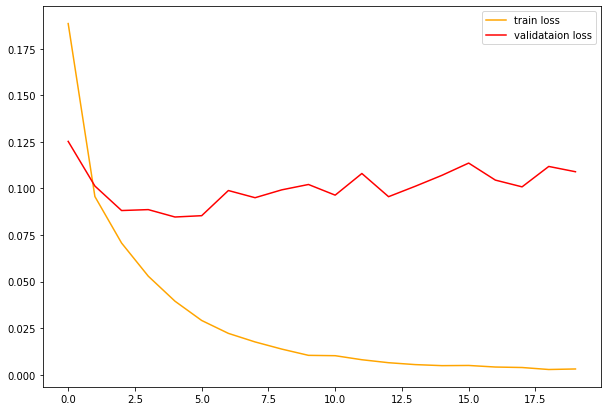

In [ ]:
plt.figure(figsize=(10, 7))
plt.plot(train_loss, color='orange', label='train loss')
plt.plot(val_loss, color='red', label='validataion loss')
plt.legend()
plt.savefig('loss_{}_norm.png'.format(modelname))
plt.show()

In [ ]:
resnet.eval()
compute_accuracy(resnet)

Accuracy of the network on the 40000 train images: 99.86 %
Accuracy of the network on the 10000 validation images: 13.69 %
Accuracy of the network on the 10000 test images: 90.27 %


In [ ]:
confusion_matrix_resnet = accuracy_per_class(resnet)

Class      Accuracy (%)
plane        92.90   
car          95.80   
bird         87.40   
cat          75.40   
deer         88.30   
dog          89.40   
frog         93.30   
horse        93.10   
ship         94.50   
truck        92.60   


**Comment:**

We notice that the accuracy of Resnet18 is better than VGG-16 by 4%, even though it has less parameters, due to its powerful feature of Residual blocks in preventing the degradation phenomena as we reach more deep layers. 

We can see that in the accuracy figures above of VGG and Resnet, where in VGG the accuracy of training dataset is getting better but on validation is relatively stable, which means that the does not generalize well on unseen data. While, for Resnet the training accuracy is stable but the validation accuracy is relatively improving each epoch signifies that the model is indeed learning new features each epoch to generalize well on unseen data. 

--------------------------------------------------------------------

# 5\ Vision Transformer (ViT)

We are considering using a new model, know as Vision Transfomer where they use Transfomers (widely used for Natural Language Processing) for Computer Vision tasks, which is a novel method. This paper is still under review considered for ICLR2021 Conference.

> - Paper: https://openreview.net/pdf?id=YicbFdNTTy
> - Code: https://github.com/lucidrains/vit-pytorch/
> - Video: https://www.youtube.com/watch?v=TrdevFK_am4

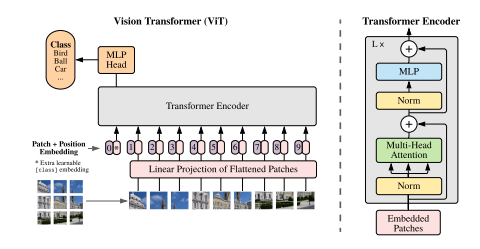

In [ ]:
!pip install vit-pytorch

In [ ]:
!pip install linformer

In [ ]:
from linformer import Linformer
from torch.optim.lr_scheduler import StepLR

from vit_pytorch.efficient import ViT

In [ ]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [ ]:
import torch
from vit_pytorch import ViT

v = ViT(
    image_size = 256,
    patch_size = 32,
    num_classes = 10,
    dim = 1024,
    depth = 6,
    heads = 8,
    mlp_dim = 2048,
    dropout = 0.1,
    emb_dropout = 0.1
)

In [ ]:
img = torch.randn(1, 3, 256, 256)
mask = torch.ones(1, 8, 8).bool() # optional mask, designating which patch to attend to

preds = v(img, mask = mask) # (1, 1000)

In [ ]:
print(preds)

tensor([[ 0.1648, -0.0970,  0.2126, -0.2272,  0.5997,  0.0704, -0.0197,  0.0541,
          0.2230, -0.3194]], grad_fn=<AddmmBackward>)


### Load Data

In [ ]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

In [ ]:
from torch.utils.data.sampler import SubsetRandomSampler

n_training_samples = 40000 # Max: 50 000 - n_val_samples
n_val_samples = 10000


train_sampler = SubsetRandomSampler(np.arange(n_training_samples, dtype=np.int64))
val_sampler = SubsetRandomSampler(np.arange(n_training_samples, n_training_samples + n_val_samples, dtype=np.int64))

train_set = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transforms)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=test_batch_size, sampler=train_sampler,
                                          num_workers=num_workers)

valid_loader = torch.utils.data.DataLoader(train_set, batch_size=128, sampler=val_sampler,
                                          num_workers=num_workers)

test_set = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transforms)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=test_batch_size,
                                         num_workers=num_workers)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Model Setup

In [ ]:
efficient_transformer = Linformer(
    dim=128,
    seq_len=49+1,  # 7x7 patches + 1 cls-token
    depth=12,
    heads=8,
    k=64
)

In [ ]:
from vit_pytorch.efficient import ViT

model = ViT(
    dim=128,
    image_size=224,
    patch_size=32,
    num_classes=10,
    transformer = efficient_transformer,
    channels = 3).to(device)

### Training

In [ ]:
# Training settings
batch_size = 64
epochs = 20
lr = 3e-5
gamma = 0.7
seed = 42

In [ ]:
import random
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [ ]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for i, (data, label) in enumerate(train_loader):
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for j, (data, label) in enumerate(val_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

In [ ]:
import os
torch.save(model.state_dict(), 'ViT_model.pt')
print(os.getcwd())
print(os.listdir())

/content
['.config', 'ViT_model.pt', 'vgg16_model.pt', 'accuracy.png', 'loss.png', 'data', 'best_model.pth', 'sample_data']


In [ ]:
model.load_state_dict(torch.load('ViT_model.pt'))

<All keys matched successfully>

In [ ]:
print("Computing accuracy...")
compute_accuracy(model)

Computing accuracy...
Accuracy of the network on the 40000 train images: 56.00 %
Accuracy of the network on the 10000 validation images: 54.23 %
Accuracy of the network on the 10000 test images: 54.67 %


**Comment:**
- This model architecture is considered as state-of-the-art for ImageNet before it is still under review for ICLR2021. After we did training above on CIFAR-10, we can observe clearly that it is not giving really good results.

-------------------------------------------------------------

# 6\ Visualization of Saliency Maps

In the following, we use FlashTorch to visualize Saliency Maps. Saliency maps are a way to visualize what a network is focusing on, when making a particular classification.

Code: https://github.com/MisaOgura/flashtorch

In [49]:
!pip install flashtorch --quiet

In [70]:
# as an example we will use the image of a frog 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plane_img1 = mpimg.imread('plane1.jpg')
plane_img2 = mpimg.imread('plane2.jpeg')
car_img1 = mpimg.imread('car1.jpg')
car_img2 = mpimg.imread('car2.jpg')
frog_img = mpimg.imread('frog.jpg')
dog_img = mpimg.imread('dog.jpg')
bird_img = mpimg.imread('bird.jpg')

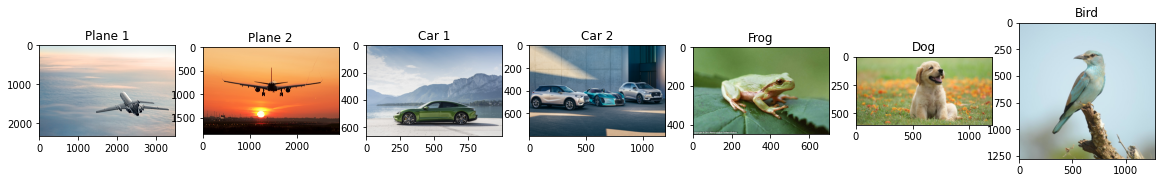

In [72]:
imgs = [plane_img1, plane_img2, car_img1, car_img2, frog_img, dog_img, bird_img]
imgs_name = ["Plane 1", "Plane 2", "Car 1", "Car 2", "Frog", "Dog", "Bird"]
fig, ax = plt.subplots(1, 7, figsize=(20, 10))
for i in range(len(imgs)):
  ax[i].imshow(imgs[i], cmap='gray')
  ax[i].set_title(imgs_name[i])

/usr/local/lib/python3.6/dist-packages/flashtorch/saliency/backprop.py:112: UserWarning: The predicted class index 908 does notequal the target class index 1. Calculating the gradient w.r.t. the predicted class.
  'Calculating the gradient w.r.t. the predicted class.'
/usr/local/lib/python3.6/dist-packages/flashtorch/saliency/backprop.py:112: UserWarning: The predicted class index 404 does notequal the target class index 1. Calculating the gradient w.r.t. the predicted class.
  'Calculating the gradient w.r.t. the predicted class.'
/usr/local/lib/python3.6/dist-packages/flashtorch/saliency/backprop.py:112: UserWarning: The predicted class index 817 does notequal the target class index 2. Calculating the gradient w.r.t. the predicted class.
  'Calculating the gradient w.r.t. the predicted class.'
/usr/local/lib/python3.6/dist-packages/flashtorch/saliency/backprop.py:112: UserWarning: The predicted class index 751 does notequal the target class index 2. Calculating the gradient w.r.t. th

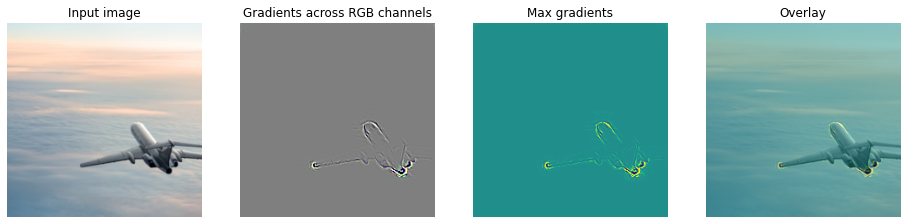

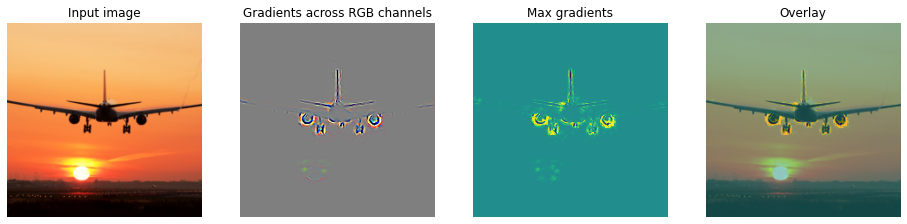

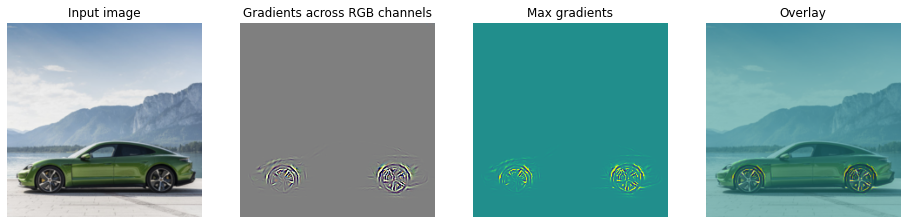

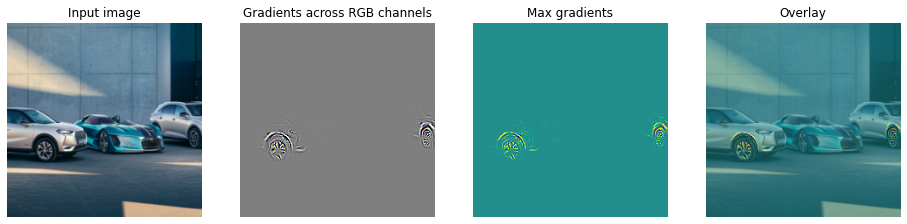

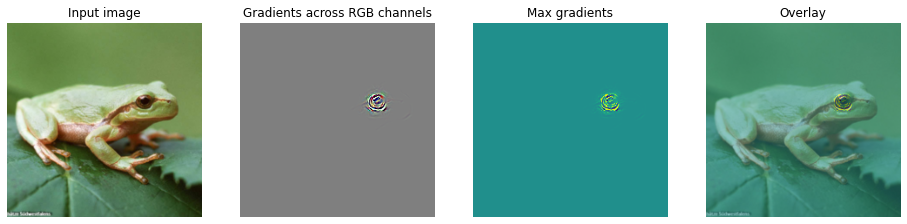

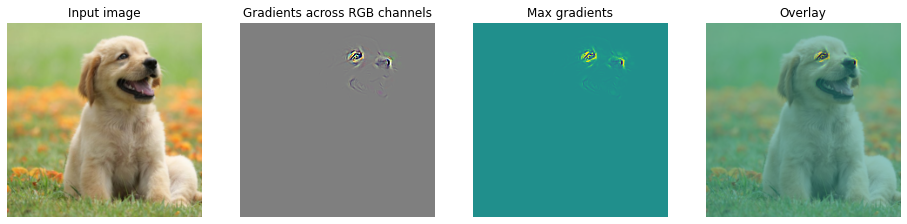

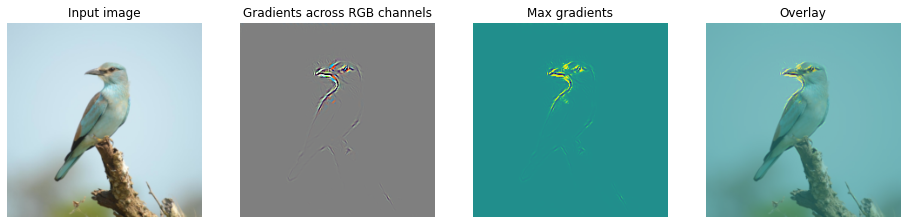

In [74]:
# FlashTorch example taken from https://github.com/MisaOgura/flashtorch/blob/master/examples/visualize_saliency_with_backprop.ipynb
from torchvision import models
from flashtorch.utils import apply_transforms, load_image
from flashtorch.saliency import Backprop

transformed_img = []
for img in imgs:
  transformed_img.append(apply_transforms(img))

# load pretrained model 
model = models.resnet18(pretrained=True)

# use saliency backpropagation on VGG16  
backprop = Backprop(model)

#classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Set a target class - tree frog 31
target_classes = [1, 1, 2, 2, 7, 6, 3]

# Ready to roll!
for i, im in enumerate(transformed_img):
  backprop.visualize(im, target_classes[i], guided=True, use_gpu=True)

**Comment:**
> - As illustrated above we notice that Resnet has learnt important features for each class of CIFAR-10, to classify accordingly. For example, the distinguishing thing of class "car" to the others classes is the wheels, whereas for the dog, frog is the eyes and for the bird is peak and eyes.

> - We observe as well, that resnet did not detect the wheels in the car of the second image, due to low variation of contrast between the body of the car and the wheel. Which should be taken into consideration for future improvements by widening the dataset samples in order for the model to generalize well.